In [2]:
!nvidia-smi

Sat Sep  3 16:03:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:03:00.0 Off |                    0 |
| N/A   27C    P0    51W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:41:00.0 Off |                    0 |
| N/A   

In [2]:
# from gigalens.jax.inference import ModellingSequence
# from gigalens.jax.model import ForwardProbModel, BackwardProbModel
# from gigalens.model import PhysicalModel
# from gigalens.jax.simulator import LensSimulator
# from gigalens.simulator import SimulatorConfig
# from gigalens.jax.profiles.light import sersic
# from gigalens.jax.profiles.mass import epl, shear

# import tensorflow_probability.substrates.jax as tfp
# import jax
# from jax import random
# import numpy as np
# import optax
# from jax import numpy as jnp
# from matplotlib import pyplot as plt
# import optax
# tfd = tfp.distributions

In [1]:
import sys
sys.path.insert(0, '/global/u2/x/xshuang/HST-modeling/HST/gigalens-xh-dev/src')

from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import sersic
from gigalens.jax.profiles.mass import epl, shear

import tensorflow_probability.substrates.jax as tfp
import jax
from jax import random
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import optax
tfd = tfp.distributions

# from inference import ModellingSequence

In [3]:
lens_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                theta_E=tfd.LogNormal(jnp.log(1.25), 0.25),
                gamma=tfd.TruncatedNormal(2, 0.25, 1, 3),
                e1=tfd.Normal(0, 0.1),
                e2=tfd.Normal(0, 0.1),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
            )
        ),
        tfd.JointDistributionNamed(
            dict(gamma1=tfd.Normal(0, 0.05), gamma2=tfd.Normal(0, 0.05))
        ),
    ]
)
lens_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(1.0), 0.15),
                n_sersic=tfd.Uniform(2, 6),
                e1=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                e2=tfd.TruncatedNormal(0, 0.1, -0.3, 0.3),
                center_x=tfd.Normal(0, 0.05),
                center_y=tfd.Normal(0, 0.05),
                Ie=tfd.LogNormal(jnp.log(500.0), 0.3),
            )
        )
    ]
)

source_light_prior = tfd.JointDistributionSequential(
    [
        tfd.JointDistributionNamed(
            dict(
                R_sersic=tfd.LogNormal(jnp.log(0.25), 0.15),
                n_sersic=tfd.Uniform(0.5, 4),
                e1=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                e2=tfd.TruncatedNormal(0, 0.15, -0.5, 0.5),
                center_x=tfd.Normal(0, 0.25),
                center_y=tfd.Normal(0, 0.25),
                Ie=tfd.LogNormal(jnp.log(150.0), 0.5),
            )
        )
    ]
)

prior = tfd.JointDistributionSequential(
    [lens_prior, lens_light_prior, source_light_prior]
)

In [4]:
kernel = np.load('./src/gigalens/assets/psf.npy').astype(np.float32)
sim_config = SimulatorConfig(delta_pix=0.065, num_pix=60, supersample=2, kernel=kernel)
phys_model = PhysicalModel([epl.EPL(50), shear.Shear()], [sersic.SersicEllipse(use_lstsq=False)], [sersic.SersicEllipse(use_lstsq=False)])
lens_sim = LensSimulator(phys_model, sim_config, bs=1)
observed_img = np.load('./src/gigalens/assets/demo.npy')
prob_model = ForwardProbModel(prior, observed_img, background_rms=0.2, exp_time=100)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [5]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-2/3, 
                                      power=0.5, transition_steps=500)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
num_steps = 20
num_samples = 20
map_estimate = model_seq.MAP(opt, seed=0, n_samples=num_samples, num_steps=num_steps)
# map_estimate = model_seq.MAP(opt, seed=0, n_samples=30, num_steps=num_steps)

  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=num_samples), map_estimate)[0]
best = map_estimate[jnp.argmax(lps)][jnp.newaxis,:]

In [8]:
schedule_fn = optax.polynomial_schedule(init_value=-1e-6, end_value=-3e-3, 
                                      power=2, transition_steps=300)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best, opt, n_vi=100, num_steps=100)
# qz, loss_hist = model_seq.SVI(best, opt, n_vi=1000, num_steps=1500)

  0%|          | 0/100 [00:00<?, ?it/s]

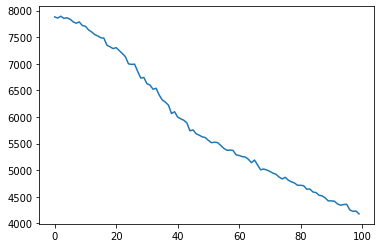

In [9]:
plt.plot(loss_hist)

In [10]:
samples = model_seq.HMC(qz, num_burnin_steps=20, num_results=70)

AttributeError: module 'tensorflow_probability.substrates.jax.experimental.mcmc' has no attribute 'ProgressBarReducer'

In [13]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)

In [14]:
rhat

DeviceArray([1.0031133, 1.0154064, 1.0300986, 1.0455794, 1.1032083,
             1.0187557, 1.0975742, 1.0426505, 1.0087693, 1.016461 ,
             1.0071555, 1.0018296, 1.0021337, 1.0007672, 1.006384 ,
             1.0650535, 1.0207828, 1.0014718, 1.0782766, 1.0090909,
             1.0064999, 1.056856 ], dtype=float32)